# Behavioural clone

Given multiple replays of expert trajectorys \[(s_1, a_1), (s_2, a_2), ...\]  
use a neural network to predict the 'a' actions from the 's' states.

In [1]:
# PARAMS
EXPERT_PLAYER_IDX = 0
USE_GPU = False

GAMES = [{"id": gameID} for gameID in ["noBoost1v1_1", "noBoost1v1_2", "noBoost1v1_3"]]

# NOTE: can't use __file__ in jupyter notebook unfortunately, so hard-code it insteadL
ROOT_PROJECT_PATH = 'C:/Users/User/code/CPSC533V/project'

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sys
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
DEVICE = torch.device("cuda" if USE_GPU else "cpu")

# Load local reusable code within 'lib/'
sys.path.append(ROOT_PROJECT_PATH)
import lib.files as libFiles
import lib.preprocess as libPreprocess
from lib.StoAModel import StoA_Model

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Parse the games from .replay files

In [4]:
for game in GAMES:
    game['data'] = libFiles.parseReplayToGameData(game['id'])
    libFiles.cleanAndDisplayGameData(game['data'])

Loading...
	replays\noBoost1v1_1.replay


Could not find field_of_view in camera settings for Sundown
Could not find height in camera settings for Sundown
Could not find pitch in camera settings for Sundown
Could not find distance in camera settings for Sundown
Could not find stiffness in camera settings for Sundown
Could not find swivel_speed in camera settings for Sundown
Could not find transition_speed in camera settings for Sundown
D:/projects/carball\carball\controls\rotations.py:87: RuntimeWarning: invalid value encountered in sign
  rhs[1] / (T_p + np.sign(rhs[1]) * omega[1] * D_p),
D:/projects/carball\carball\controls\rotations.py:88: RuntimeWarning: invalid value encountered in sign
  rhs[2] / (T_y - np.sign(rhs[2]) * omega[2] * D_y)


2 players loaded!

Orange team:
	bot

Blue team:
	expert

12921 data points acquired
====


Loading...
	replays\noBoost1v1_2.replay


Could not find field_of_view in camera settings for Beast
Could not find height in camera settings for Beast
Could not find pitch in camera settings for Beast
Could not find distance in camera settings for Beast
Could not find stiffness in camera settings for Beast
Could not find swivel_speed in camera settings for Beast
Could not find transition_speed in camera settings for Beast


2 players loaded!

Orange team:
	bot

Blue team:
	expert

12016 data points acquired
====


Loading...
	replays\noBoost1v1_3.replay


Could not find field_of_view in camera settings for Middy
Could not find height in camera settings for Middy
Could not find pitch in camera settings for Middy
Could not find distance in camera settings for Middy
Could not find stiffness in camera settings for Middy
Could not find swivel_speed in camera settings for Middy
Could not find transition_speed in camera settings for Middy


2 players loaded!

Orange team:
	bot

Blue team:
	expert

12682 data points acquired
====




In [5]:
# For debugging purposes, check the values loaded:
print ("Player values recorded:")
for pp in list(GAMES[0]['data'].players[0].data):
    print (" * " + pp)
    
print ("\nBall values recorded:")
for bp in list(GAMES[0]['data'].ball):
    print (" * " + bp)

Player values recorded:
 * ping
 * pos_x
 * pos_y
 * pos_z
 * rot_x
 * rot_y
 * rot_z
 * vel_x
 * vel_y
 * vel_z
 * ang_vel_x
 * ang_vel_y
 * ang_vel_z
 * throttle
 * steer
 * handbrake
 * ball_cam
 * boost
 * boost_active
 * jump_active
 * double_jump_active
 * dodge_active
 * boost_collect

Ball values recorded:
 * pos_x
 * pos_y
 * pos_z
 * rot_x
 * rot_y
 * rot_z
 * vel_x
 * vel_y
 * vel_z
 * ang_vel_x
 * ang_vel_y
 * ang_vel_z
 * hit_team_no


## Preprocess all loaded data

Keep only needed values, fill in missing ones, and normalize all ranges.

In [6]:
for game in GAMES:
    gameData = game['data']
    
    game['playerStates'], game['playerActions'] = [], []
    for p in gameData.players:
        game['playerStates' ].append(libPreprocess.cleanPlayerStates( p.data    ))
        game['playerActions'].append(libPreprocess.cleanPlayerActions(p.controls))
    game['ballStates'] = libPreprocess.cleanBallStates(gameData.ball)
    print ("Game data from '%s' preprocessed." % game['id'])
    print ("    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys\n")
    

Game data from 'noBoost1v1_1' preprocessed.
    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys

Game data from 'noBoost1v1_2' preprocessed.
    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys

Game data from 'noBoost1v1_3' preprocessed.
    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys



## Distrubutions of values

Histogram for the distribution of values of each state and columns

Player states:


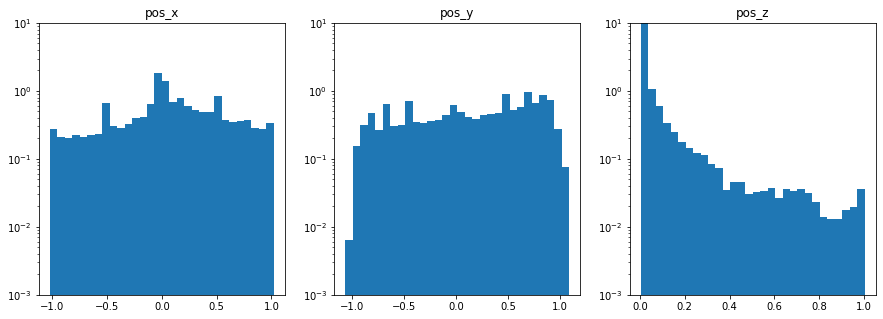

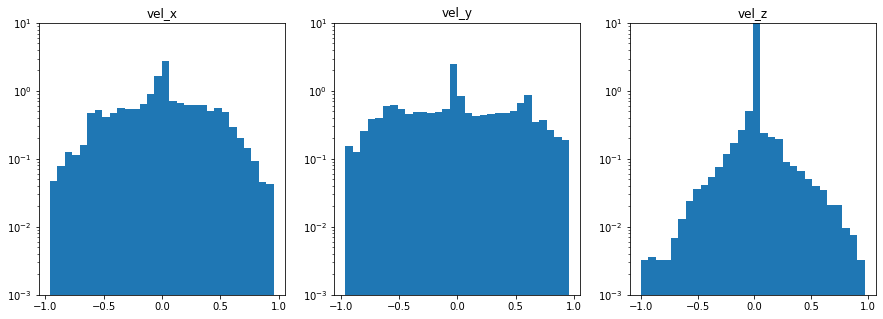

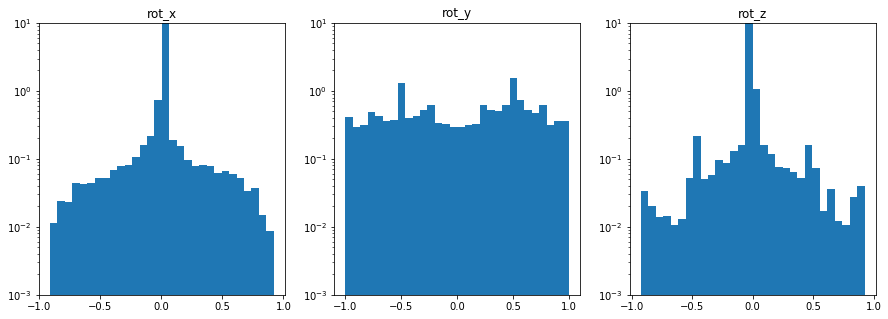

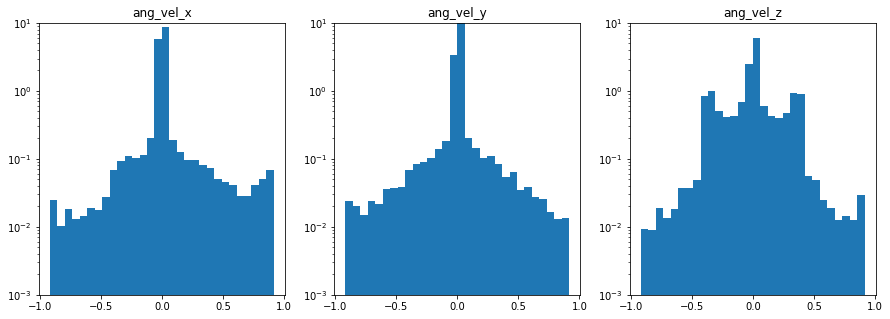

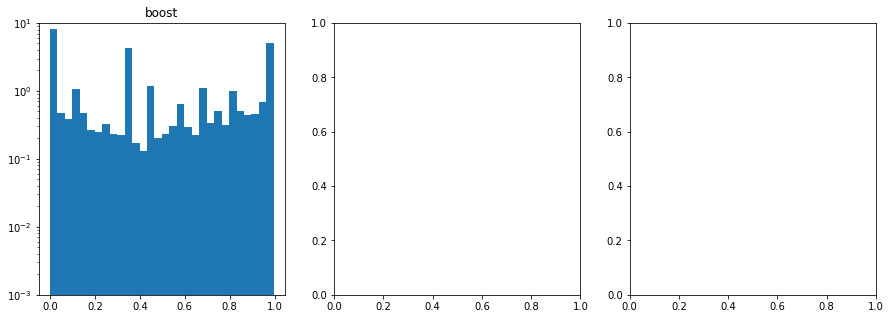

Player actions:


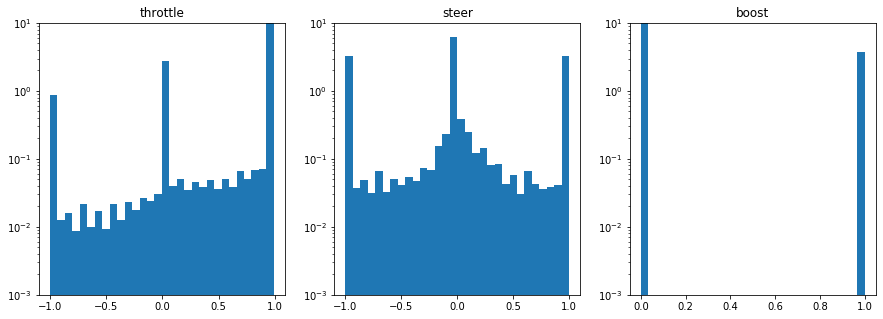

Ball states:


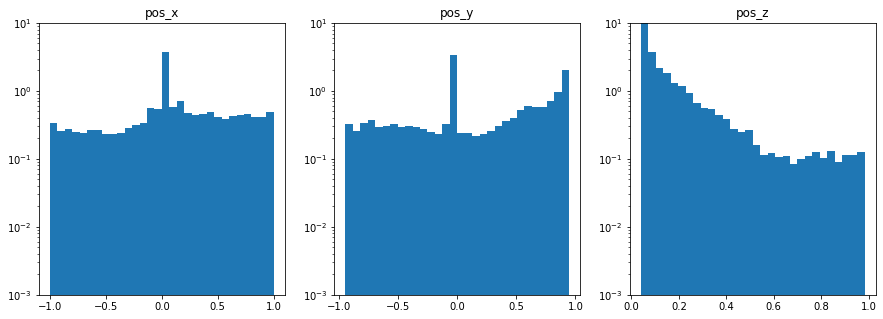

In [7]:
def showDistributions():
    print ("Player states:")

    allPlayerStates  = [s for game in GAMES for s in game['playerStates'] ]
    allPlayerActions = [a for game in GAMES for a in game['playerActions']]
    allBallStates    = [game['ballStates'] for game in GAMES]
    
    for i in range(0, len(libPreprocess.PLAYER_STATE_KEYS), 3):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for j in range(3):
            if i + j >= len(libPreprocess.PLAYER_STATE_KEYS):
                break
            key = libPreprocess.PLAYER_STATE_KEYS[i + j]
            allValues = []
            for pState in allPlayerStates:
                allValues.extend(pState[key].values)
            ax[j].hist(allValues, log=True, bins=30, density=True)
            ax[j].set_title(key)
            ax[j].set_ylim((1e-3, 10))
        plt.show()

    print ("Player actions:")
    for i in range(0, len(libPreprocess.PLAYER_ACTION_KEYS), 3):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for j in range(3):
            if i + j >= len(libPreprocess.PLAYER_ACTION_KEYS):
                break
            key = libPreprocess.PLAYER_ACTION_KEYS[i + j]
            allValues = []
            for pAct in allPlayerActions:
                allValues.extend(pAct[key].values * 1.0)
            ax[j].hist(allValues, log=True, bins=30, density=True)
            ax[j].set_title(key)
            ax[j].set_ylim((1e-3, 10))
        plt.show()

    print ("Ball states:")
    for i in range(0, len(libPreprocess.BALL_STATE_KEYS), 3):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for j in range(3):
            if i + j >= len(libPreprocess.BALL_STATE_KEYS):
                break
            key = libPreprocess.BALL_STATE_KEYS[i + j]
            allValues = []
            for bState in allBallStates:
                allValues.extend(bState[key].values)
            ax[j].hist(allValues, log=True, bins=30, density=True)
            ax[j].set_title(key)
            ax[j].set_ylim((1e-3, 10))
        plt.show()
    
showDistributions()

## Extract expert states and actions

Combine ball state and all player states into one dataframe, labelled appropriately for the expert player.


In [8]:
for game in GAMES:
    game['expertStates'], game['expertActions'] = libPreprocess.stateAndActionsForPlayer(game, EXPERT_PLAYER_IDX)
    print ("State and action maps for player %s" % game['data'].players[EXPERT_PLAYER_IDX].name)
    print (game['expertStates'].values.shape, game['expertStates'].values.dtype)
    print (game['expertActions'].values.shape, game['expertActions'].values.dtype)
    print ("=======\n\n")

State and action maps for player expert
(12921, 29) float64
(12921, 3) object


State and action maps for player expert
(12016, 29) float64
(12016, 3) object


State and action maps for player expert
(12682, 29) float64
(12682, 3) object




## Train the model

Using all the data, collect into batches and train the model for a number of epochs,  
and save the result to file for use within the game.

In [9]:
TOTAL_EPOCHS = 500
BATCH_SZ = 50
#PRINT_INTERVAL = 1000
LOG_INTERVAL = 1000
LEARNING_RATE = 0.003
REGULARIZER_WEIGHT = 3e-2

W_ALOSS = 100
W_DLOSS = 50

writer = SummaryWriter()

def train_behavioral_cloning(dataBatches, model):
    # Adam optimizer usually a good default.
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZER_WEIGHT)
    
    # MSE loss for [-1, 1] continuous variables:
    analog_loss_func = torch.nn.MSELoss().to(DEVICE)
    
    # Cross entropy loss for binary variables:
    digital_loss_func = torch.nn.BCEWithLogitsLoss().to(DEVICE)

    gradient_steps = 0

    for epoch in range(1, TOTAL_EPOCHS + 1):
        batchShuffled = random.sample(dataBatches, len(dataBatches))
        lastLoss = -1
        for iteration, data in enumerate(batchShuffled):
            data = {k: v.to(DEVICE) for k, v in data.items()}
            output = model(data['s'])
            analogAction = 2 * torch.sigmoid(data['aAnalog']) - 1
            digitalAction = data['aDigital']
            
            aasz = len(libPreprocess.PLAYER_ANALOG_ACTION_KEYS)
            aLoss = W_ALOSS * analog_loss_func(output[:, :aasz], analogAction)
            dLoss = W_DLOSS * digital_loss_func(output[:, aasz:], digitalAction)
            loss = aLoss + dLoss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if gradient_steps % LOG_INTERVAL == 0:
                writer.add_scalar('analogLoss', aLoss.item(), gradient_steps)
                writer.add_scalar('digitalLoss', dLoss.item(), gradient_steps)
                writer.add_scalar('loss', loss.item(), gradient_steps)
            
            gradient_steps += 1
            
            if iteration == len(batchShuffled) - 1:
                lastLoss = loss.item()
            
        print ('[epoch {:4d}/{}] [iter {:7d}] [loss {:.5f}]'.format(
           epoch, TOTAL_EPOCHS, gradient_steps, lastLoss)
        )
    
def runTraining():
    combinedStates  = pd.concat([game['expertStates']  for game in GAMES])
    combinedActions = pd.concat([game['expertActions'] for game in GAMES])
    
    dataBatches, stateSz, actionAnalogSz, actionDigitalSize = \
        libPreprocess.dataToBatches(combinedStates, combinedActions, BATCH_SZ, splitActions=True)
    
    model = StoA_Model(stateSz, actionAnalogSz + actionDigitalSize, DEVICE)
    train_behavioral_cloning(dataBatches, model)
    model.save("bc_boostOnly1v1_All3")
    return model

model = runTraining()


37619 rows, 29 state dim, 3 action dim, into 753 batches of size 50
[epoch    1/500] [iter     753] [loss 28.27473]
[epoch    2/500] [iter    1506] [loss 18.71646]
[epoch    3/500] [iter    2259] [loss 16.04131]
[epoch    4/500] [iter    3012] [loss 18.17970]
[epoch    5/500] [iter    3765] [loss 17.01349]
[epoch    6/500] [iter    4518] [loss 14.84415]
[epoch    7/500] [iter    5271] [loss 18.06255]
[epoch    8/500] [iter    6024] [loss 12.95009]
[epoch    9/500] [iter    6777] [loss 16.56463]
[epoch   10/500] [iter    7530] [loss 17.35343]
[epoch   11/500] [iter    8283] [loss 25.78239]
[epoch   12/500] [iter    9036] [loss 12.47660]
[epoch   13/500] [iter    9789] [loss 20.41401]
[epoch   14/500] [iter   10542] [loss 18.93468]
[epoch   15/500] [iter   11295] [loss 16.14409]
[epoch   16/500] [iter   12048] [loss 16.68266]
[epoch   17/500] [iter   12801] [loss 11.85096]
[epoch   18/500] [iter   13554] [loss 13.49997]
[epoch   19/500] [iter   14307] [loss 12.34973]
[epoch   20/500] [it

[epoch  171/500] [iter  128763] [loss 12.66085]
[epoch  172/500] [iter  129516] [loss 12.46053]
[epoch  173/500] [iter  130269] [loss 14.68805]
[epoch  174/500] [iter  131022] [loss 12.10521]
[epoch  175/500] [iter  131775] [loss 9.61810]
[epoch  176/500] [iter  132528] [loss 21.10047]
[epoch  177/500] [iter  133281] [loss 20.33535]
[epoch  178/500] [iter  134034] [loss 19.31745]
[epoch  179/500] [iter  134787] [loss 18.05598]
[epoch  180/500] [iter  135540] [loss 20.81705]
[epoch  181/500] [iter  136293] [loss 12.48131]
[epoch  182/500] [iter  137046] [loss 15.11687]
[epoch  183/500] [iter  137799] [loss 11.31631]
[epoch  184/500] [iter  138552] [loss 14.69481]
[epoch  185/500] [iter  139305] [loss 13.00585]
[epoch  186/500] [iter  140058] [loss 13.56218]
[epoch  187/500] [iter  140811] [loss 14.94377]
[epoch  188/500] [iter  141564] [loss 9.73670]
[epoch  189/500] [iter  142317] [loss 24.64273]
[epoch  190/500] [iter  143070] [loss 15.58130]
[epoch  191/500] [iter  143823] [loss 20.3

[epoch  342/500] [iter  257526] [loss 15.92740]
[epoch  343/500] [iter  258279] [loss 10.27994]
[epoch  344/500] [iter  259032] [loss 18.23012]
[epoch  345/500] [iter  259785] [loss 16.37237]
[epoch  346/500] [iter  260538] [loss 11.20610]
[epoch  347/500] [iter  261291] [loss 19.13105]
[epoch  348/500] [iter  262044] [loss 17.03453]
[epoch  349/500] [iter  262797] [loss 13.10195]
[epoch  350/500] [iter  263550] [loss 7.12693]
[epoch  351/500] [iter  264303] [loss 15.61162]
[epoch  352/500] [iter  265056] [loss 18.03312]
[epoch  353/500] [iter  265809] [loss 15.00646]
[epoch  354/500] [iter  266562] [loss 15.44182]
[epoch  355/500] [iter  267315] [loss 18.39532]
[epoch  356/500] [iter  268068] [loss 15.04172]
[epoch  357/500] [iter  268821] [loss 8.99653]
[epoch  358/500] [iter  269574] [loss 12.56906]
[epoch  359/500] [iter  270327] [loss 16.12654]
[epoch  360/500] [iter  271080] [loss 16.04745]
[epoch  361/500] [iter  271833] [loss 9.61454]
[epoch  362/500] [iter  272586] [loss 15.86

NameError: name 'os' is not defined